In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ddeint import ddeint
def compute_fwhm(t, y):
    """
    Compute Full Width at Half Maximum (FWHM) for a 1D time series y(t).
    
    Parameters:
    - t: time points (1D array)
    - y: signal values (1D array)
    
    Returns:
    - fwhm_time: duration for which y > 0.5 * max(y)
    - t_start, t_end: time bounds of FWHM interval
    """
    half_max = 0.5 * np.max(y)
    above_half = y > half_max
    if not np.any(above_half):
        return 0.0, None, None

    indices = np.where(above_half)[0]
    t_start = t[indices[0]]
    t_end = t[indices[-1]]
    fwhm_time = t_end - t_start
    return fwhm_time, t_start, t_end


def init_simulation (d1 = 0.1):
    # Define parameter values from Table 1
    k1, k2, k3 = 4.0, 0.3, 0.1     # rate constants
    d2, d3 = 0.7, 0.12    # degradation rates
    b1, b2 = 10, 80
    K1, K2 = 33, 0.1
    n1, n2 = 1, 1

    # Time delays (in hours)
    tau1, tau2, tau3, tau4, tau5 = 12, 8, 7, 9, 5

    # Hill functions
    def hill_up(x, K, n):
        return x**n / (K**n + x**n)

    def hill_down(x, K, n):
        return K**n / (K**n + x**n)

    # ODE system with delays
    def model(Y, t):
        V = Y(t)[0]
        I = Y(t)[1]
        A = Y(t)[2]

        V_tau1 = Y(t - tau1)[0] if t - tau1 > 0 else hist(t - tau1)[0]
        A_tau5 = Y(t - tau5)[2] if t - tau5 > 0 else hist(t - tau5)[2]
        V_tau2 = Y(t - tau2)[0] if t - tau2 > 0 else hist(t - tau2)[0]
        I_tau4 = Y(t - tau4)[1] if t - tau4 > 0 else hist(t - tau4)[1]
        I_tau3 = Y(t - tau3)[1] if t - tau3 > 0 else hist(t - tau3)[1]

        dVdt = k1 * V_tau1 * b1 * hill_down(A_tau5, K1, n1) - d1 * V
        dIdt = k2 * V_tau2 + b2 * hill_up(I_tau4, K2, n2) - d2 * I
        dAdt = k3 * I_tau3 - d3 * A

        return np.array([dVdt, dIdt, dAdt])

    # History function for t < 0
    def hist(t):
        return np.array([100, 10, 2])  # initial conditions: V(0), I(0), A(0)

    # Time grid
    tt = np.linspace(0, 100, 1000)

    # Solve the system
    yy = ddeint(model, hist, tt)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(tt, yy[:, 0], label='Virus (V)', linewidth=2)
    plt.plot(tt, yy[:, 1], label='Interferon (I)', linewidth=2)
    plt.plot(tt, yy[:, 2], label='AVP (A)', linewidth=2)
    plt.xlabel('Time (hours)')
    plt.ylabel('Concentration')
    plt.title('Dynamics of Virus, IFN, and AVP')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    fwhm_v,_,_ = compute_fwhm(tt, yy[:,0])
    fwhm_i,_,_ = compute_fwhm(tt, yy[:,1])

    return fwhm_v, fwhm_i


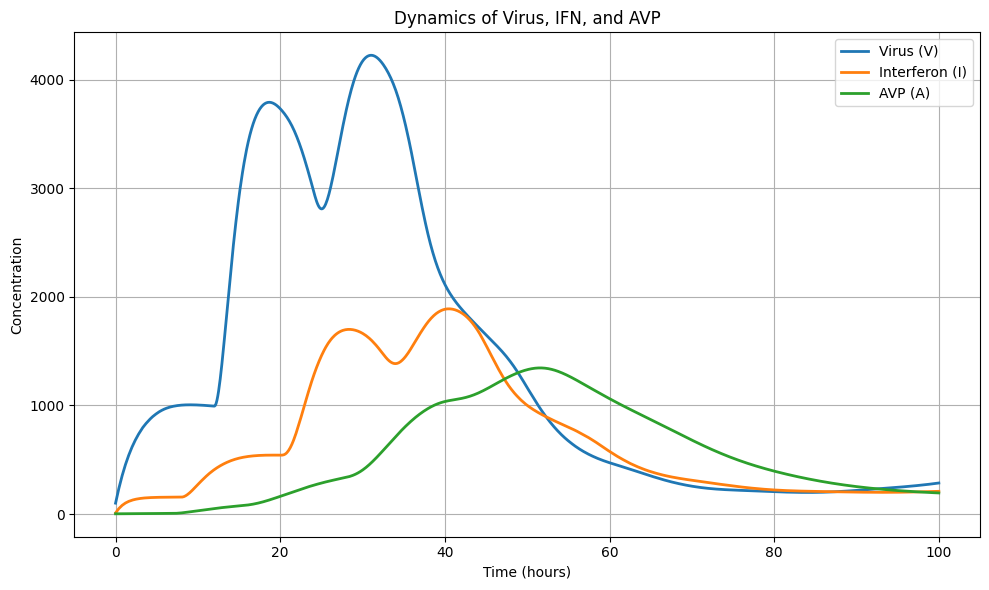

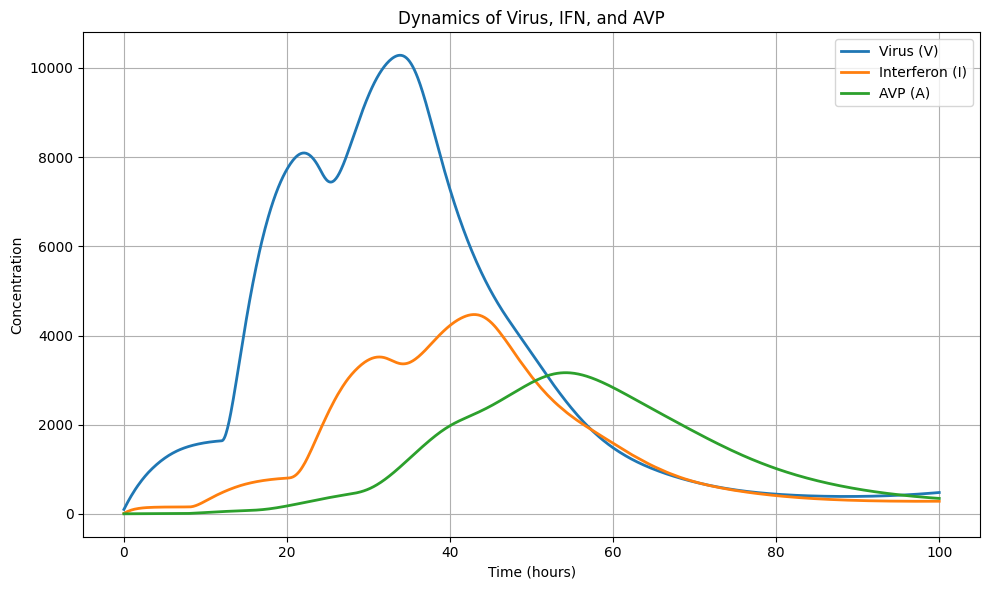

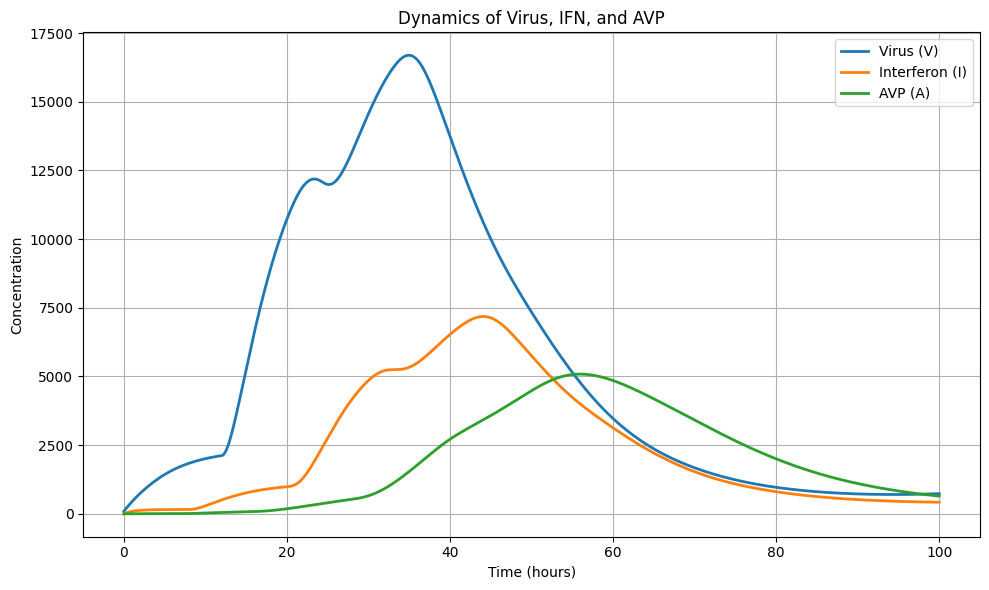

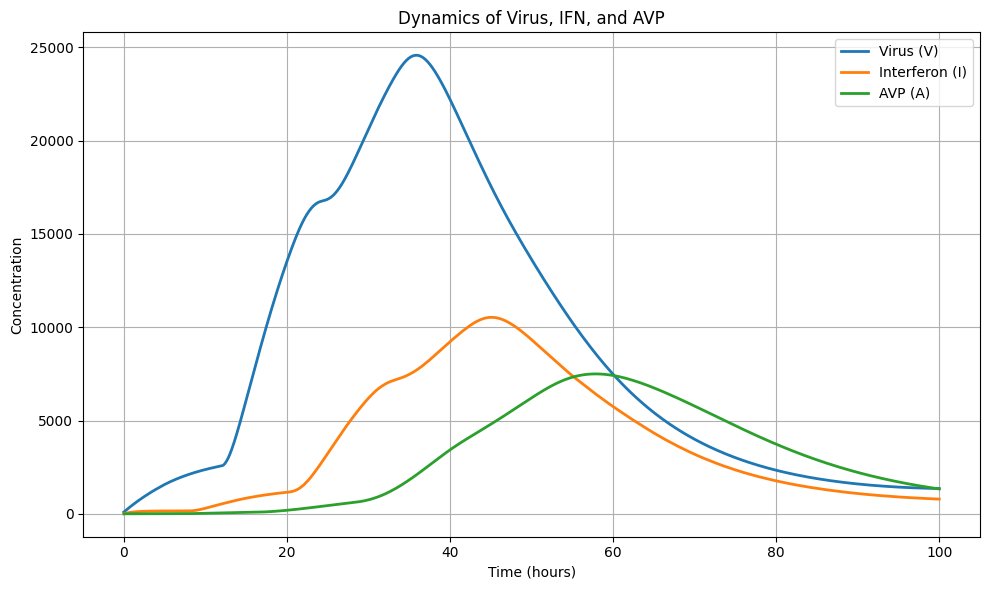

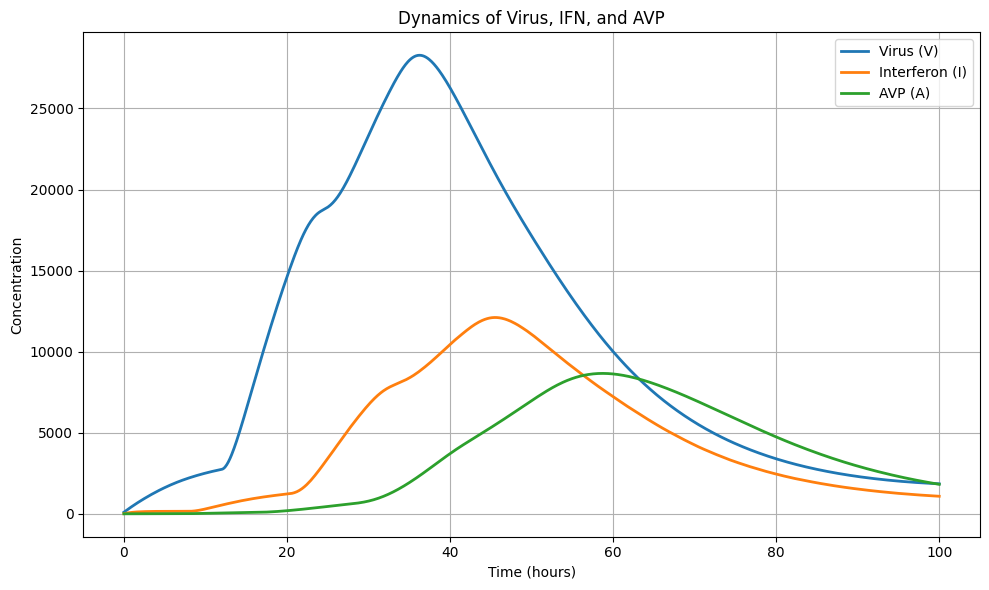

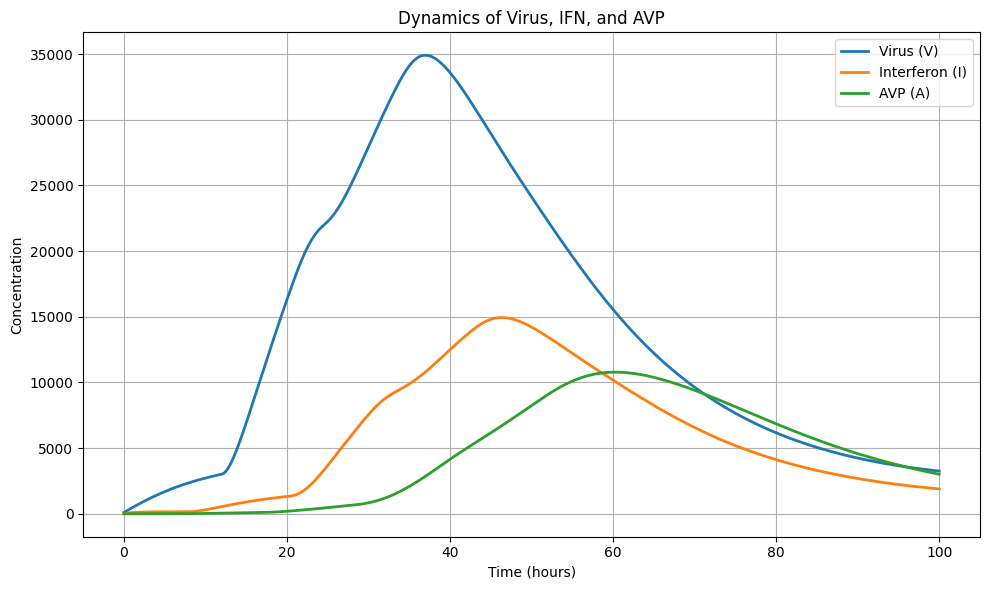

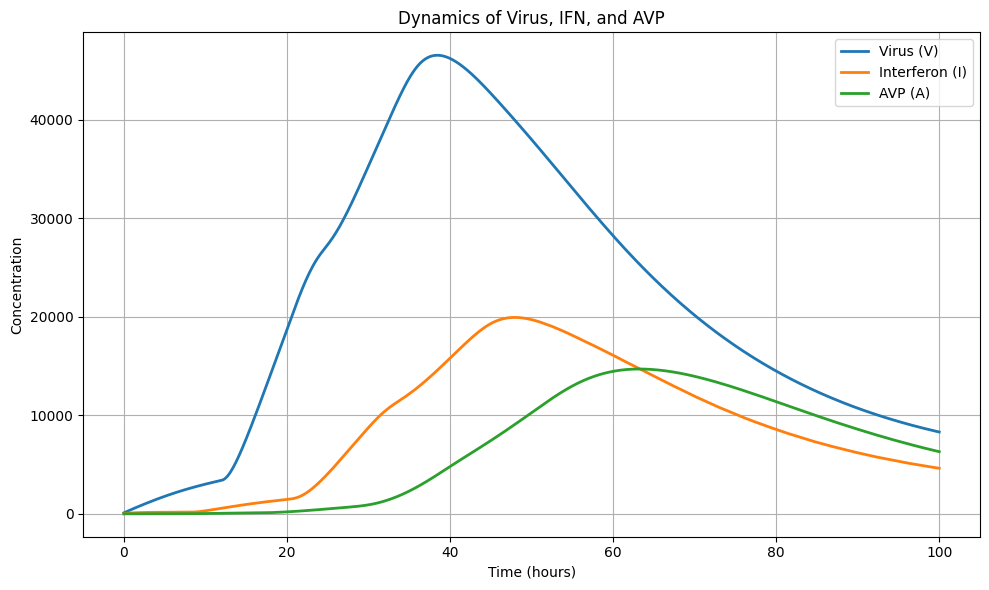

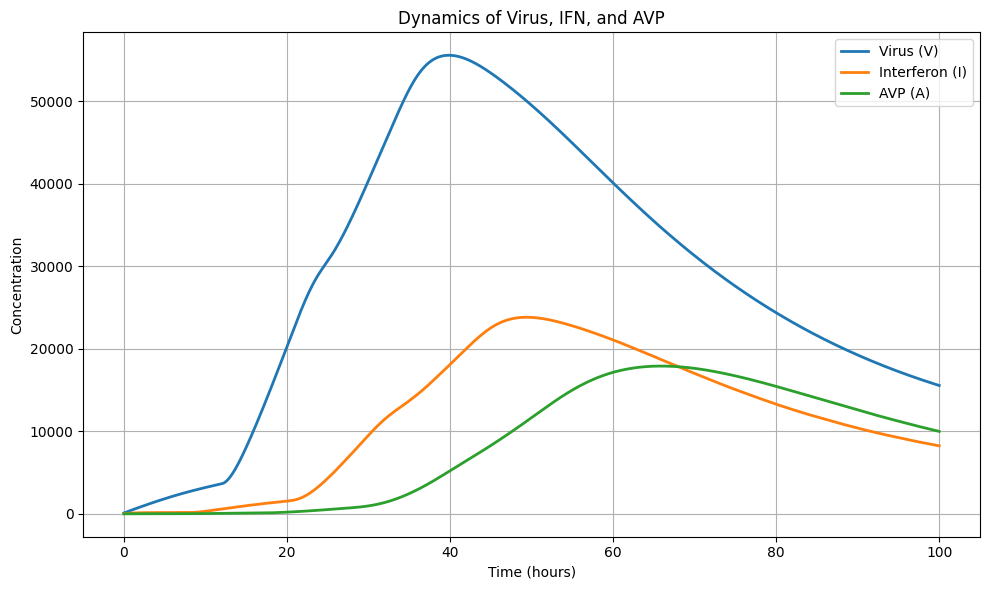

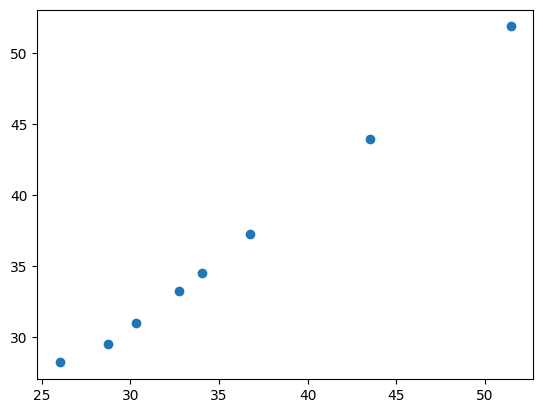

In [13]:
fwhm_vs = []
fwhm_is = []
for d1 in [0.35, 0.2, 0.14, 0.1, 0.087,  0.069, 0.047, 0.035]:
    fwhm_v, fwhm_i = init_simulation(d1)
    fwhm_vs.append(fwhm_v)
    fwhm_is.append(fwhm_i)

fig,ax = plt.subplots()
ax.scatter(fwhm_vs, fwhm_is)

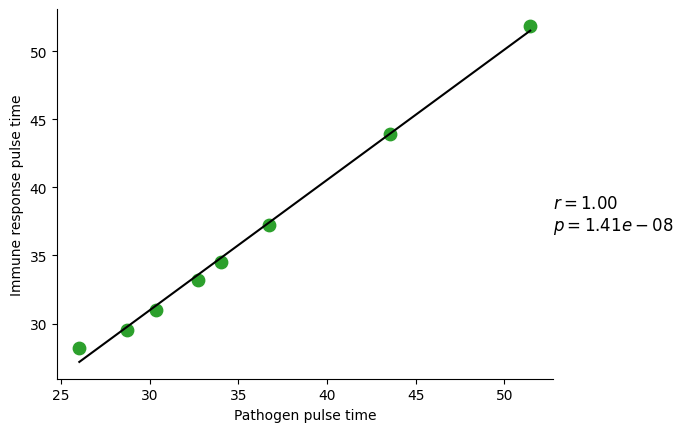

In [16]:
fig,ax = plt.subplots()
ax.spines[['top','right']].set_visible(False)
ax.scatter(fwhm_vs,fwhm_is,s = 80, color = 'tab:green')

from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(fwhm_vs,fwhm_is)
y_fit = slope * np.array(fwhm_vs) + intercept
ax.plot(fwhm_vs, y_fit, color='black', label=f'Fit: y={slope:.2f}x+{intercept:.2f}')
ax.text(1, 0.5, f'$r = {r_value:.2f}$ \n$ p = {p_value:.2e}$', transform=plt.gca().transAxes,
    verticalalignment='top', fontsize=12)

ax.set_xlabel('Pathogen pulse time')
ax.set_ylabel('Immune response pulse time')
fig.savefig('tan_corr.png',dpi = 600)
fig.savefig('tan_corr.pdf',dpi = 600)



In [18]:
fwhms = np.array([fwhm_vs,fwhm_is])
np.save('tan_fwhms',fwhms)
